In [1]:
def seed_everything(seed: int):
    import random, os
    import numpy as np
    import torch
    
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

# Seed everything to make results reproducible
seed_everything(42)

In [2]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# Read the dataset
file_path = "dataset.tsv"
df = pd.read_csv(file_path, sep='\t')

from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
import nltk
import textacy
import textacy.preprocessing as tprep

stopwords = [tprep.remove.accents(word) for word in stopwords.words("turkish")]

# Tokenize the Turkish text so that it is ready to be used as features
def tokenize(text):
    text = text.lower()                                                           # lowercase the text
    text = text.translate(str.maketrans('', '', string.punctuation))              # remove punctuation
    text = tprep.normalize.unicode(text)                                          # normalize unicode
    text = tprep.remove.accents(text)                                             # remove accents
    text = word_tokenize(text, language='turkish')                                # split the text into words
    text = [word for word in text if not word in stopwords]                       # remove unnecessary noise words
    return text

In [4]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['Comment'], df['Score'], test_size=0.2, random_state=42)

# Convert the text into TF-IDF vectors
# Learn the vocabulary dictionary and return term-document matrix on the training set
# Transform documents to document-term matrix on the testing set
tfidf_vectorizer = TfidfVectorizer(max_features=5000, tokenizer=tokenize)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

/Users/obi/opt/miniconda3/envs/dl/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [5]:
# Define the parameter grid for Naive Bayes
param_grid = {
    'alpha': [0.05, 0.1, 0.5, 1.0, 2.0]
}

# Create a Multinomial Naive Bayes classifier
nb_classifier = MultinomialNB()

# Create the GridSearchCV object for Naive Bayes
grid_search = GridSearchCV(estimator=nb_classifier, param_grid=param_grid, cv=5, n_jobs=-1)

# Fit the model to the training data
grid_search.fit(X_train_tfidf, y_train)

# Print the best parameters and the corresponding F1 score
print("Best Parameters:", grid_search.best_params_)
print("Best Accuracy:", grid_search.best_score_)

Best Parameters: {'alpha': 0.1}
Best Accuracy: 0.8233312731767615


In [6]:
# Get the best model
best_nb_model = grid_search.best_estimator_

# Train the final Naive Bayes model with the best hyperparameters
best_nb_model.fit(X_train_tfidf, y_train)

# Make predictions on the test set
predictions = best_nb_model.predict(X_test_tfidf)

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Calculate precision, recall, and F1 score
report = classification_report(y_test, predictions, output_dict=True)
precision = report['weighted avg']['precision']
recall = report['weighted avg']['recall']
f1 = report['weighted avg']['f1-score']

# Display the classification report and confusion matrix
print("\nClassification Report:\n", classification_report(y_test, predictions))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, predictions))
print("\nPrecision:", f"{(precision * 100):.2f}")
print("Recall:", f"{(recall * 100):.2f}")
print("F1 Score:", f"{(f1 * 100):.2f}")
print("Accuracy:", f"{(accuracy_score(y_test, predictions) * 100):.2f}")


Classification Report:
               precision    recall  f1-score   support

           1       0.70      0.66      0.68       381
           2       0.22      0.02      0.03       113
           3       0.43      0.08      0.14       272
           4       0.40      0.07      0.12       937
           5       0.84      0.99      0.91      6387

    accuracy                           0.82      8090
   macro avg       0.52      0.36      0.38      8090
weighted avg       0.76      0.82      0.77      8090


Confusion Matrix:
 [[ 252    3    6    6  114]
 [  34    2    3    9   65]
 [  24    2   23   39  184]
 [  11    0   18   65  843]
 [  41    2    3   42 6299]]

Precision: 75.99
Recall: 82.09
F1 Score: 76.68
Accuracy: 82.09


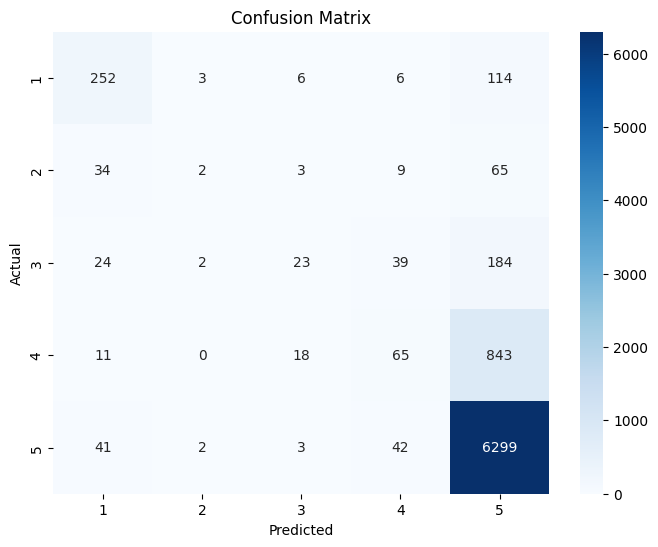

In [7]:
# Generate confusion matrix
cm = confusion_matrix(y_test, predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=sorted(df['Score'].unique()), yticklabels=sorted(df['Score'].unique()))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

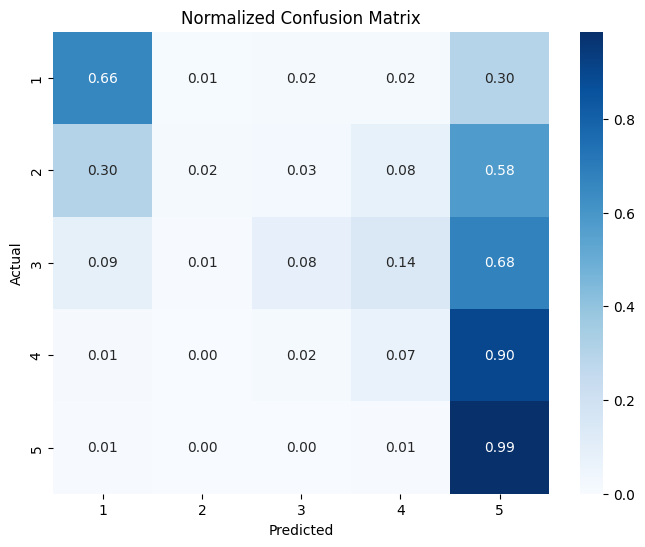

In [8]:
# Normalize the confusion matrix to analyze smaller classes better
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot normalized confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=sorted(df['Score'].unique()), yticklabels=sorted(df['Score'].unique()))
plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [9]:
# Save the predictions for statitical significance test
with open("nb_preds.npy", "wb") as f:
    np.save(f, predictions)

In [10]:
# Save the gold labels for statitical significance test
with open("nb_golds.npy", "wb") as f:
    np.save(f, y_test.to_numpy())

## OOD Part

In [11]:
import pandas as pd

# Load the OOD dataset
file_path = "OsmanBaturInce_ood_dataset.tsv"
df = pd.read_csv(file_path, sep='\t', header=None, names=["Comment", "Score", "Link", "Brand", "Type"])

In [12]:
# Just acquire the features and scores to make predictions with the best model
X = tfidf_vectorizer.transform(df["Comment"])
y = df["Score"]

In [13]:
# Perform predictions with the best model
predictions = best_nb_model.predict(X)

In [14]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Calculate precision, recall, and F1 score
report = classification_report(y, predictions, output_dict=True)
precision = report['weighted avg']['precision']
recall = report['weighted avg']['recall']
f1 = report['weighted avg']['f1-score']

# Display the classification report and confusion matrix
print("\nClassification Report:\n", classification_report(y, predictions))
print("\nConfusion Matrix:\n", confusion_matrix(y, predictions))
print("\nPrecision:", f"{(precision * 100):.2f}")
print("Recall:", f"{(recall * 100):.2f}")
print("F1 Score:", f"{(f1 * 100):.2f}")
print("Accuracy:", f"{(accuracy_score(y, predictions) * 100):.2f}")


Classification Report:
               precision    recall  f1-score   support

           1       0.43      0.27      0.33        11
           2       1.00      0.17      0.29         6
           3       0.33      0.03      0.05        36
           4       0.39      0.09      0.15       117
           5       0.87      0.98      0.92      1012

    accuracy                           0.85      1182
   macro avg       0.60      0.31      0.35      1182
weighted avg       0.80      0.85      0.81      1182


Confusion Matrix:
 [[  3   0   1   0   7]
 [  0   1   0   0   5]
 [  1   0   1   2  32]
 [  0   0   0  11 106]
 [  3   0   1  15 993]]

Precision: 80.19
Recall: 85.36
F1 Score: 81.02
Accuracy: 85.36


In [15]:
# Save the OOD predictions for statitical significance test
with open("nb_ood_preds.npy", "wb") as f:
    np.save(f, predictions)

In [16]:
# Save the OOD gold scores for statitical significance test
with open("nb_ood_golds.npy", "wb") as f:
    np.save(f, y.to_numpy())